In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm


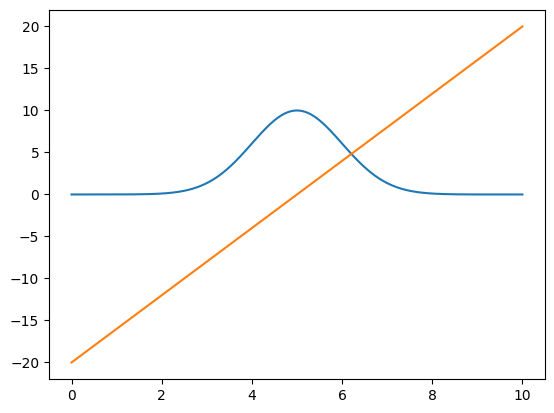

In [3]:
T_max = 10
times = np.linspace(0, T_max, 500)
sigma = 1
omega_max = 10
omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
delta_t = lambda t: 2*omega_max*(t / (T_max/2) - 1)

plt.plot(times, omega_t(times))
plt.plot(times, delta_t(times))

In [4]:
X = sigmax()
Z = sigmaz()
Y = sigmay()
I = qeye(2)

s1 = tensor(Z, Z, I)
s2 = tensor(I, Z, Z)
S = [s1, s2]
X_L = tensor(X, X, X)
Z_L = (tensor(Z, I, I) + tensor(I, Z, I) + tensor(I, I, Z)) / 3
# Z_L = tensor(Z, Z, Z)
logical_zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
logical_one = X_L * logical_zero
initial_state = logical_zero
n_qubits = 3


P1 = logical_one*logical_one.dag()

In [28]:
# T_max = 10
# times = np.linspace(0, T_max, 500)
# sigma = 1
# omega_max = 10
# omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
# delta_t = lambda t: 2*(t / (T_max/2) - 1)
# 
# 
# def H(t):
#     """
#     Rapid Adiabatic Hamiltonian
#     """
#     return  X_L * omega_t(t) + Z_L * delta_t(t)
# 
# # write a function that checks if a given hamiltonian follows the adiabatic theorem
# def check_adabatic(H, initial_state, times):
#     """
#     Check if the given Hamiltonian follows the adiabatic theorem
#     """
#     results = sesolve(H, initial_state, times, e_ops=[P1])
#     fidelity = results.expect[0][-1]
#     return 1 - fidelity
# 
# # test the function
# infidelity = check_adabatic(H, logical_zero, times)
# print(f"Infidelity: {infidelity:.4f}")

# Checking infidelity of the protocol as a function of the total runtime T
* energy gap protection does not change the infidelity

Total Runtime: 100%|██████████| 1000/1000 [00:09<00:00, 103.88it/s]


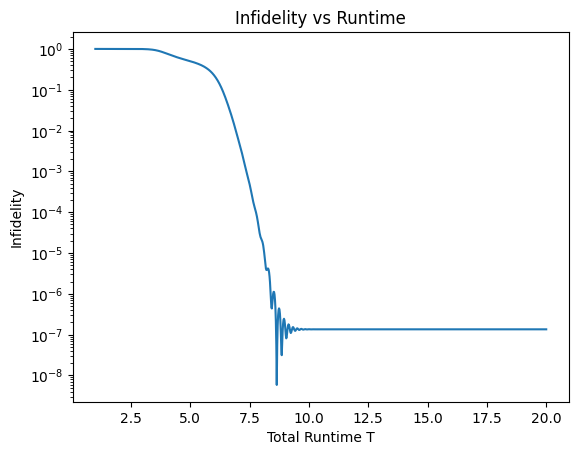

In [29]:
runtimes = np.linspace(1, 2*T_max, 1000)

def H(t):
    """
    Rapid Adiabatic Hamiltonian
    """
    return  X_L * omega_t(t) + Z_L * delta_t(t)

infiedelities = []
for T in tqdm(runtimes, desc="Total Runtime"):
    times = np.linspace(0, T, 100)
    results = sesolve(H, logical_zero, times, e_ops=[P1])
    infiedelities.append(1 - results.expect[0][-1])

plt.title("Infidelity vs Runtime")
# plt.plot(runtimes, infiedelities, "o")
plt.semilogy(runtimes, infiedelities)
plt.ylabel("Infidelity")
plt.xlabel("Total Runtime T")
plt.show()

# Checking infidelity of the protocol as a function of the maximum frequency $\Omega_{max}$
* energy gap protection does not change the infidelity

In [30]:
omega_maxs = np.linspace(-5*10, 5*10, 1000)

T = 10
times = np.linspace(0, T, 50)
infiedelities = {}

for scale in [0.2, 1]:
    infiedelities[scale] = []
    for omega_max in tqdm(omega_maxs, desc="Omega Max"):
        omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
        delta_t = lambda t: scale*omega_max*(t / (T_max/2) - 1)
        def H(t):
            return  X_L * omega_t(t) + Z_L * delta_t(t)
        
        results = sesolve(H, logical_zero, times, e_ops=[P1])
        infiedelities[scale].append(1 - results.expect[0][-1])

Omega Max: 100%|██████████| 1000/1000 [00:08<00:00, 111.16it/s]


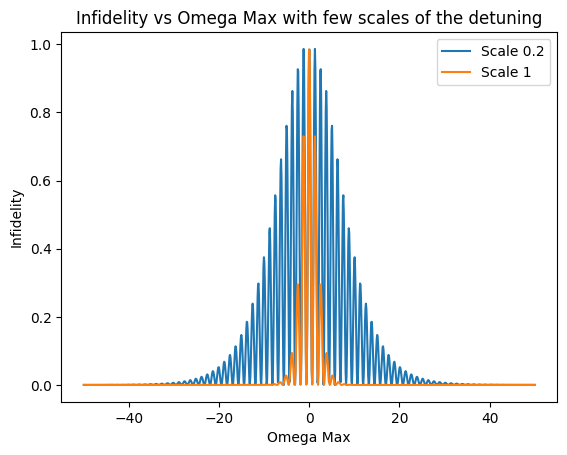

In [31]:
plt.title("Infidelity vs Omega Max with few scales of the detuning")
# plt.plot(omega_maxs, infiedelities, "o")
for scale, infidelity in infiedelities.items():
    plt.plot(omega_maxs, infidelity, label=f"Scale {scale}")
plt.ylabel("Infidelity")
plt.xlabel("Omega Max")
plt.legend()
plt.show()

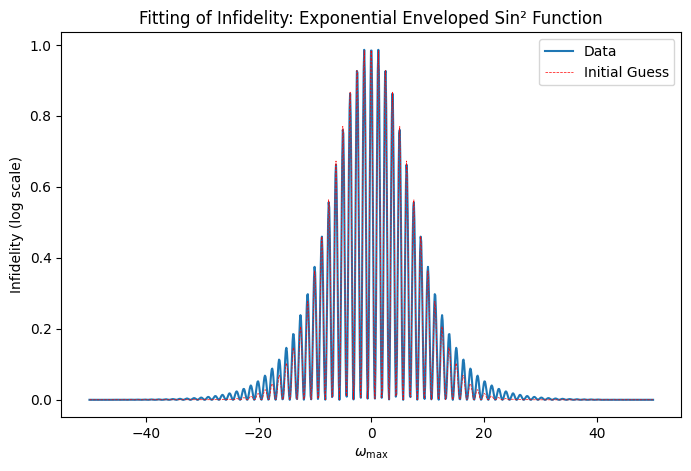

In [32]:
from scipy.optimize import curve_fit

# Define the fitting function: exponential envelope multiplied by squared sine.
def fitting_func(omega_max, A, B):
    return np.exp(-omega_max**2 / A) * np.cos(B*omega_max)**2

def fitting_func_guess(omega_max):
    """
    should be lorenzian insted of gaussian envelope
    :param omega_max: 
    :return: 
    """
    return np.exp(-omega_max**2 / 100) * np.cos(2.5*omega_max)**2


scale = 0.2
# Fit the data using curve_fit with an initial parameter guess.
# initial_guess = [100, 2.5]
initial_guess = [scale]
# params_opt, params_cov = curve_fit(fitting_func_lorenz, omega_maxs, infiedelities[scale], p0=initial_guess)

# Plot the original data and the resulting fit (using a semilog scale for the y-axis).
plt.figure(figsize=(8, 5))
plt.plot(omega_maxs, infiedelities[scale], label='Data')
plt.plot(omega_maxs, fitting_func_guess(omega_maxs), label='Initial Guess', linestyle='--', color='red', linewidth=0.5)
plt.xlabel(r'$\omega_{\max}$')
plt.ylabel('Infidelity (log scale)')
plt.title('Fitting of Infidelity: Exponential Enveloped Sin² Function')
plt.legend()
plt.show()

# # print also the R**2 of the fit
# residuals = infiedelities[scale] - fitting_func_lorenz(omega_maxs, *params_opt)
# ss = np.sum(residuals**2)
# ss_tot = np.sum((infiedelities[scale] - np.mean(infiedelities[scale]))**2)
# r_squared = 1 - (ss / ss_tot)
# print(f"R^2: {r_squared:.4f}")
# print(params_opt)

Checking infidelity of the protocol as a function of runtime
* energy gap protection does not change the infidelity

In [33]:
omega_maxs = np.linspace(0.1, 5*10, 1000)

infiedelities = {}

for T in [1, 5, 7, 9, 10, 20]:
    infiedelities[T] = []
    times = np.linspace(0, T, 50)
    for omega_max in tqdm(omega_maxs, desc="Omega Max"):
        omega_t = lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2)
        delta_t = lambda t: omega_max*(t / (T_max/2) - 1)
        def H(t):
            return  X_L * omega_t(t) + Z_L * delta_t(t)
        
        results = sesolve(H, logical_zero, times, e_ops=[P1])
        infiedelities[T].append(1 - results.expect[0][-1])

Omega Max: 100%|██████████| 1000/1000 [00:27<00:00, 36.91it/s]


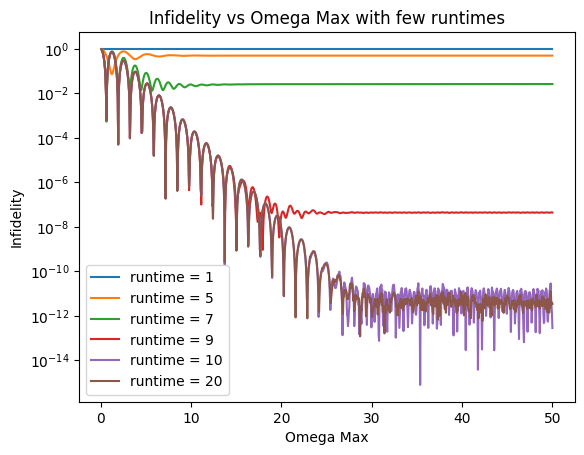

In [34]:
plt.title("Infidelity vs Omega Max with few runtimes")
# plt.plot(omega_maxs, infiedelities, "o")
for T, infidelity in infiedelities.items():
    # plt.plot(omega_maxs, infidelity, label=f"runtime = {T}")
    plt.semilogy(omega_maxs, infidelity, label=f"runtime = {T}")
plt.ylabel("Infidelity")
plt.xlabel("Omega Max")
plt.legend()
plt.show()

# Checking infidelity of the protocol as a function of the pulse duration of the π-pulse

Text(0.5, 1.0, 'Pi Pulse')

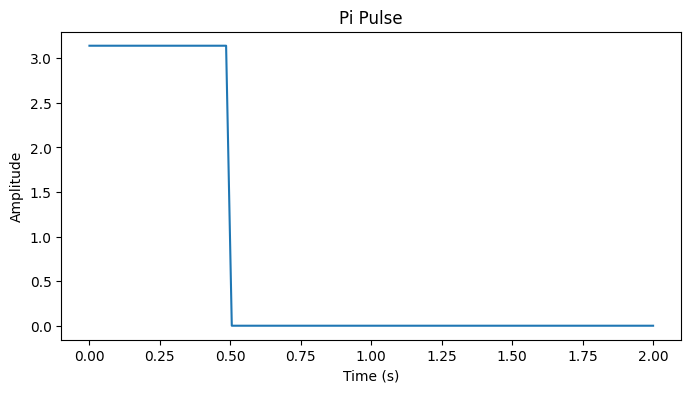

In [35]:
def pi_pulse(t, args):
    T_pulse = args['T_pulse']  # Pulse duration
    A = np.pi / T_pulse  # Amplitude of the π-pulse

    # Define the start and end times of the pulse
    t_start = - T_pulse / 2
    t_end = T_pulse / 2

    # Return amplitude if within the pulse duration
    return A if t_start <= t <= t_end else 0


# Simulation parameters
T_pulse = 1  # Duration of the π-pulse (shortened)
T_protocol = 2  # Total protocol duration (extended)
times = np.linspace(0, T_protocol, 100)  # Time range for the evolution
args = {'T_pulse': T_pulse, 'T_protocol': T_protocol}  # Arguments for the Hamiltonian

plt.figure(figsize=(8, 4))
plt.plot(times, [pi_pulse(t, args) for t in times])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Pi Pulse')

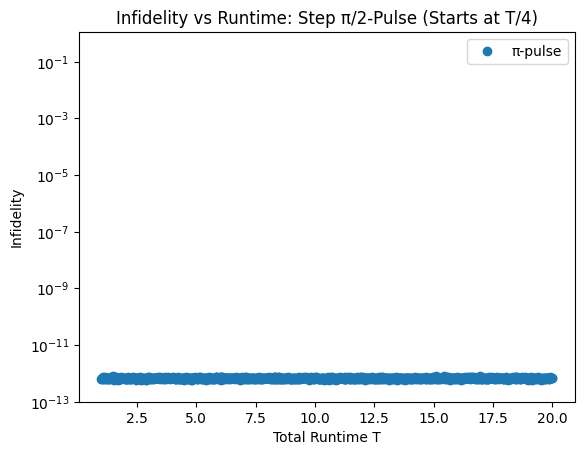

In [36]:
infidelities_pi = []
for T in runtimes:    
    T_pulse = T/2  # Duration of the π-pulse
    T_protocol = T  # Total protocol duration
    args = {'T_pulse': T_pulse, 'T_protocol': T_protocol}  # Arguments for the Hamiltonian
        
    def H_pi(t, args):
        return pi_pulse(t, args) * X_L

    times = np.linspace(0, T, 500)
    
    result = sesolve(H_pi, logical_zero, times, e_ops=[P1], args=args)
    fidelity = result.expect[0][-1]
    infidelity = 1 - fidelity
    infidelities_pi.append(infidelity)


plt.figure()
plt.title("Infidelity vs Runtime: Step π/2-Pulse (Starts at T/4)")
plt.semilogy(runtimes, infidelities_pi, "o", label="π-pulse")
# plt.plot(runtimes, infidelities_pi, "o-", label="π-pulse")
plt.ylim([1e-13,1.1])
plt.ylabel("Infidelity")
plt.xlabel("Total Runtime T")
plt.legend()
plt.show()

# trying different pulse shapes

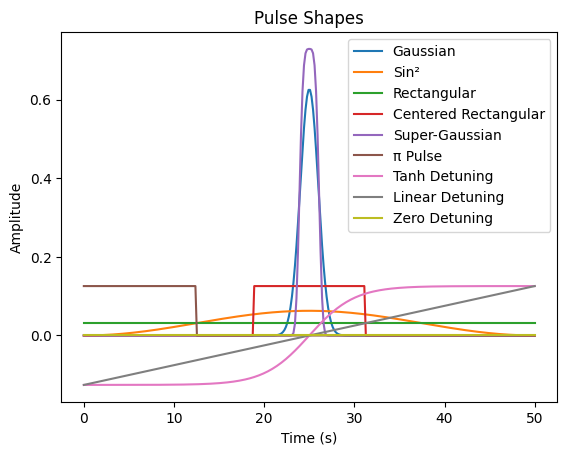

In [5]:
from scipy.integrate import quad

# Parameters
T_max = 50
sigma = 1
omega_max = 10
runtimes = np.linspace(1, T_max, 1000)
num_of_iters = 50
width_fraction = 0.25

# Pulse area normalization target
# target_area = quad(lambda t: omega_max * np.exp(-0.5 * ((t - T_max/2) / sigma) ** 2), 0, T_max)[0]
target_area = np.pi / 2

# Pulse shapes
def gaussian_pulse(t, T):
    norm = target_area /  quad(lambda t: np.exp(-0.5 * ((t - T/2) / sigma) ** 2), 0, T)[0]
    return norm * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)

def sin_squared_pulse(t, T):
    norm = target_area / quad(lambda t: np.sin(np.pi * t / T)**2, 0, T)[0]
    return norm * (np.sin(np.pi * t / T) ** 2)

def rectangular_pulse(t, T):
    return target_area / T

def super_gaussian_pulse(t, T, order=4):
    norm = target_area / quad(lambda t: np.exp(-0.5 * ((t - T/2) / sigma) ** order), 0, T)[0]
    return norm * np.exp(-0.5 * ((t - T/2) / sigma) ** order)

def centered_rectangular_pulse(t, T, width_fraction=width_fraction):
    w = T * width_fraction
    h = target_area / w
    return h if abs(t - T/2) <= w/2 else 0.0

def pi_pulse(t, T):
    A = target_area / (T/4)  # Amplitude of the π-pulse
    return A if 0 <= t <= T/4 else 0

# Detuning functions
def linear_detuning(t, T, width_fraction=width_fraction):
    w = T * width_fraction
    h = target_area / w
    return h * (t / (T / 2) - 1)

def tanh_detuning(t, T, width_fraction=width_fraction):
    w = T * width_fraction
    h = target_area / w
    return h * np.tanh(10 * (t - T / 2) / T)

def zero_detuning(t, T):
    return 0.0

# Plotting pulse shapes on the same figure
times_10 = np.linspace(0, T_max, 300)
plt.figure()
plt.title("Pulse Shapes")
plt.plot(times_10, [gaussian_pulse(t, T_max) for t in times_10], label='Gaussian')
plt.plot(times_10, [sin_squared_pulse(t, T_max) for t in times_10], label='Sin²')
plt.plot(times_10, [rectangular_pulse(t, T_max) for t in times_10], label='Rectangular')
plt.plot(times_10, [centered_rectangular_pulse(t, T_max) for t in times_10], label='Centered Rectangular')
plt.plot(times_10, [super_gaussian_pulse(t, T_max, 4) for t in times_10], label='Super-Gaussian')
plt.plot(times_10, [pi_pulse(t, T_max) for t in times_10], label='π Pulse')
plt.plot(times_10, [tanh_detuning(t, T_max) for t in times_10], label='Tanh Detuning')
plt.plot(times_10, [linear_detuning(t, T_max) for t in times_10], label='Linear Detuning')
plt.plot(times_10, [zero_detuning(t, T_max) for t in times_10], label='Zero Detuning')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()


# Combine into dicts
pulse_shapes = {
    'Gaussian': gaussian_pulse,
    'Sin²': sin_squared_pulse,
    'Rectangular': rectangular_pulse,
    'Centered Rectangular': centered_rectangular_pulse,
    'pi Pulse': pi_pulse,
    'Super-Gaussian': lambda t, T: super_gaussian_pulse(t, T, 4)
}

detuning_profiles = {
    'Linear': linear_detuning,
    'Tanh': tanh_detuning,
    'Zero': zero_detuning
}

In [6]:
# Run simulations
results_dict = {}
for d_name, delta_t in detuning_profiles.items():
    for p_name, omega_t in pulse_shapes.items():
        infidelities = []
        for T in tqdm(runtimes, desc=f"{p_name} + {d_name}"):
            H_t = lambda t, args: X_L * omega_t(t, T) + Z_L * delta_t(t, T)
            result = sesolve(H_t, logical_zero, np.linspace(0, T, num_of_iters), e_ops=[P1])
            fidelity = result.expect[0][-1]
            infidelities.append(1 - fidelity)
        results_dict[(p_name, d_name)] = infidelities

Super-Gaussian + Zero: 100%|██████████| 1000/1000 [00:04<00:00, 236.77it/s]


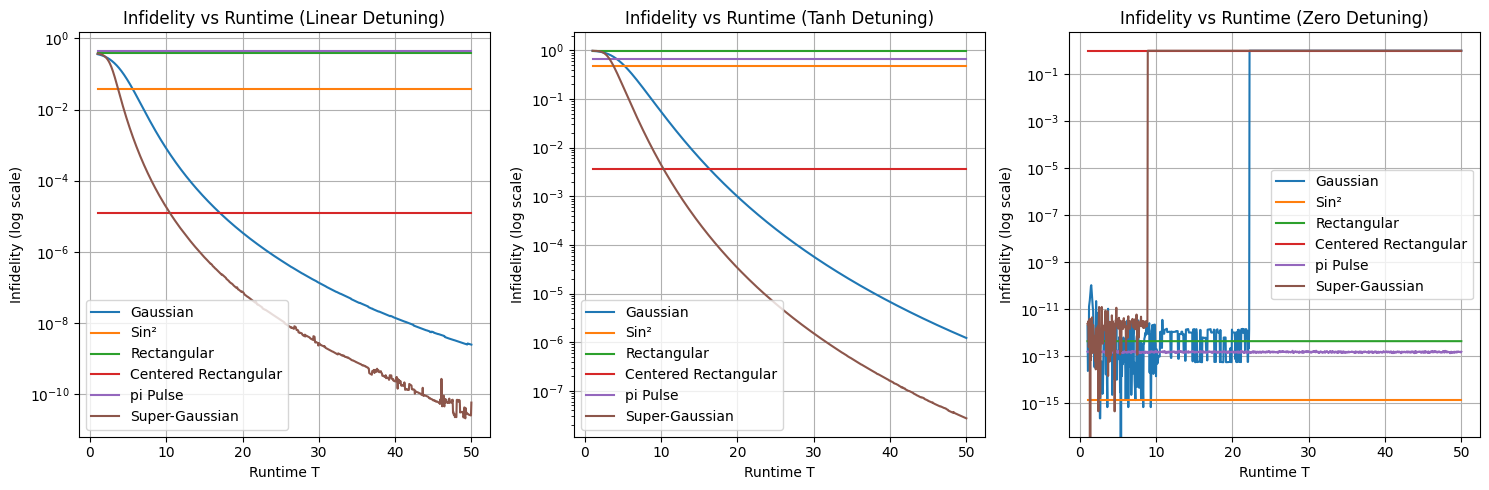

In [7]:
num_profiles = len(detuning_profiles)
plt.figure(figsize=(15, 5))
for i, d_name in enumerate(detuning_profiles):
    ax = plt.subplot(1, num_profiles, i + 1)
    for p_name in pulse_shapes:
        ax.semilogy(runtimes, results_dict[(p_name, d_name)], label=p_name)
    ax.set_title(f"Infidelity vs Runtime ({d_name} Detuning)")
    ax.set_xlabel("Runtime T")
    ax.set_ylabel("Infidelity (log scale)")
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()

Super-Gaussian: 100%|██████████| 1000/1000 [03:46<00:00,  4.41it/s]


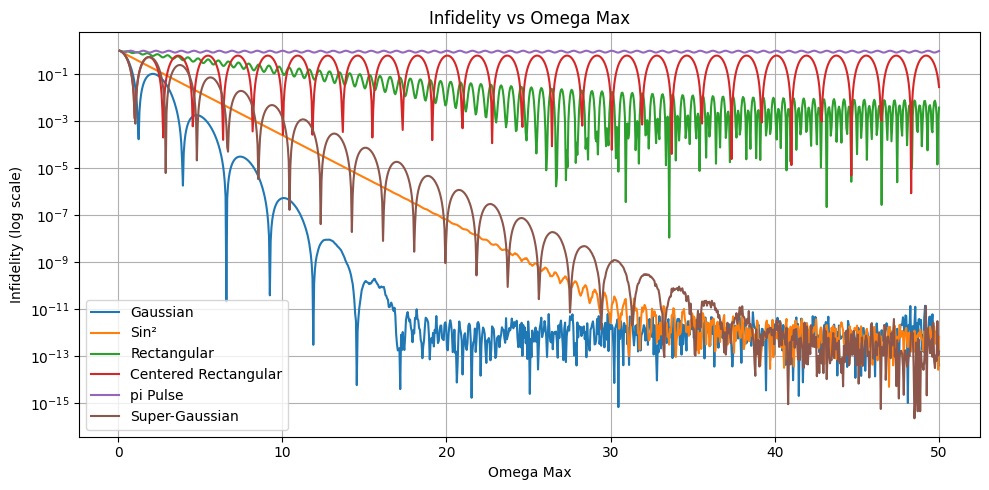

In [8]:
# do the same for the pulse shapes and different omega_max given a constant runtime

# Fixed simulation parameters
T_const = 10              # Constant runtime
num_of_iters = 50         # Number of time steps in simulation
times = np.linspace(0, T_const, num_of_iters)
# omega_maxs already defined in the workspace

omega_maxs = np.linspace(0.1, 5 * omega_max, 1000)

results_omega = {}

# Loop over pulse shapes
for p_name, pulse in pulse_shapes.items():
    infidelities = []
    for omega_max in tqdm(omega_maxs, desc=f"{p_name}"):
        # Scale the pulse shape by ωₘₐₓ
        omega_func = lambda t: omega_max * pulse(t, T_const)
        # Use a fixed linear detuning profile
        delta_func = lambda t: 2 * omega_max * (t / (T_const / 2) - 1)
        # Define Hamiltonian with constant runtime T_const
        H = lambda t, args: X_L * omega_func(t) + Z_L * delta_func(t)
        result = sesolve(H, logical_zero, times, e_ops=[P1])
        fidelity = result.expect[0][-1]
        infidelities.append(1 - fidelity)
    results_omega[p_name] = infidelities

# Plot the results
plt.figure(figsize=(10, 5))
for p_name in pulse_shapes:
    plt.semilogy(omega_maxs, results_omega[p_name], label=p_name)
plt.title("Infidelity vs Omega Max")
plt.xlabel("Omega Max")
plt.ylabel("Infidelity (log scale)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()